# Data Preprocessing

In [151]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2

In [152]:
dataPath = '/kaggle/input/catdata/dataset/Images'
trianPath = '/kaggle/input/catdata/train.csv'
trainCsv = pd.read_csv(trianPath, sep=',')

In [153]:
train_df, test_df = train_test_split(trainCsv,
                                     test_size=0.3,
                                     shuffle=True,
                                     stratify=trainCsv['classify'],
                                     random_state=20)
train_df, vali_df = train_test_split(train_df,
                                    test_size=0.3,
                                    shuffle=True,
                                    stratify=train_df['classify'],
                                    random_state=20)

class_weight = compute_class_weight(class_weight='balanced', classes=train_df.classify.unique(), y=train_df.classify) 
class_weight = {item[0]:item[1] for item in enumerate(class_weight)}

In [154]:
x_test = np.array([img_to_array(load_img(os.path.join(dataPath, imgPath)))/255. for imgPath in test_df.file])
y_test = test_df.classify.to_numpy()

In [155]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(23, 7))
# for idx in trainCsv.breed.unique():
#     plt.bar(idx, trainCsv[trainCsv.breed == idx].breed.count())
#     plt.text(idx, trainCsv[trainCsv.breed == idx].breed.count(), trainCsv[trainCsv.breed == idx].breed.count(), ha='center')

In [156]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   zoom_range=[0.8, 1.1],
                                   width_shift_range=[-0.05, 0.05],
                                   height_shift_range=[-0.05, 0.05])
vali_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    dataPath,
                                                    x_col='file',
                                                    y_col='breed',
                                                    target_size=(96, 96),
                                                    class_mode='sparse',
                                                    shuffle=True)
vali_generator = vali_datagen.flow_from_dataframe(vali_df,
                                                  dataPath,
                                                  x_col='file',
                                                  y_col='breed',
                                                  target_size=(96, 96),
                                                  class_mode='sparse',
                                                  shuffle=True)
# test_generator = test_datagen.flow_from_dataframe(test_df,
#                                                   dataPath,
#                                                   x_col='file',
#                                                   y_col='breed',
#                                                   traget_size=(224, 224),
#                                                   class_mode='categorical',
#                                                   batch_size=1,
#                                                   shuffle=True)

Found 403 validated image filenames belonging to 16 classes.
Found 173 validated image filenames belonging to 16 classes.


# Create Model and Train

In [157]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [158]:
input_tensor = layers.Input((96, 96, 3))
pretrained_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet',)
for layer in pretrained_model.layers:
    layer.trainable = False

x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(16, activation='softmax')(x)
model = models.Model(pretrained_model.input, outputs)

In [159]:
# model.summary()
# plot_model(model, show_shapes=True)

In [160]:
model.compile(optimizer=optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(patience=10)
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      patience=3,
                                                      factor=0.5,
                                                      min_lr=0.0001,
                                                      verbose=2)
# cp = callbacks.ModelCheckpoint(filepath='/kaggle/working/InceptionV3_model_ckpt', save_weight_only=True, verbose=2)
callback = [early_stopping, learning_rate_reduction]


In [161]:
hist = model.fit(train_generator,
                 validation_data=vali_generator,
                 callbacks=[callback],
                 epochs=100,
                 class_weight=class_weight,
                 verbose=2)

Epoch 1/100
13/13 - 2s - loss: 3.4254 - accuracy: 0.1216 - val_loss: 2.5341 - val_accuracy: 0.2023
Epoch 2/100
13/13 - 2s - loss: 2.9764 - accuracy: 0.1985 - val_loss: 2.2162 - val_accuracy: 0.3584
Epoch 3/100
13/13 - 2s - loss: 2.6774 - accuracy: 0.2233 - val_loss: 2.0517 - val_accuracy: 0.4162
Epoch 4/100
13/13 - 2s - loss: 2.4287 - accuracy: 0.3325 - val_loss: 1.9313 - val_accuracy: 0.4220
Epoch 5/100
13/13 - 2s - loss: 2.1637 - accuracy: 0.3499 - val_loss: 1.7973 - val_accuracy: 0.4509
Epoch 6/100
13/13 - 2s - loss: 2.0589 - accuracy: 0.4342 - val_loss: 1.7515 - val_accuracy: 0.5029
Epoch 7/100
13/13 - 2s - loss: 1.9947 - accuracy: 0.4442 - val_loss: 1.6399 - val_accuracy: 0.5029
Epoch 8/100
13/13 - 2s - loss: 1.8875 - accuracy: 0.4739 - val_loss: 1.5876 - val_accuracy: 0.5029
Epoch 9/100
13/13 - 2s - loss: 1.8402 - accuracy: 0.4888 - val_loss: 1.5911 - val_accuracy: 0.5376
Epoch 10/100
13/13 - 2s - loss: 1.7769 - accuracy: 0.5112 - val_loss: 1.4822 - val_accuracy: 0.5318
Epoch 11/

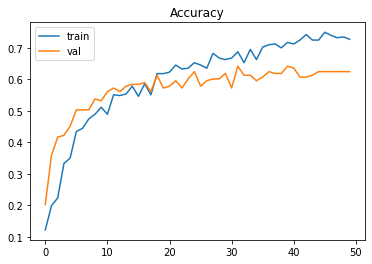

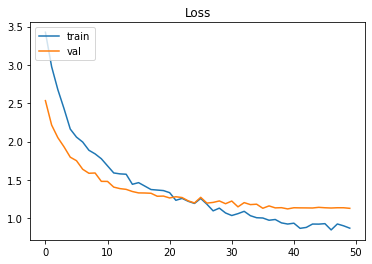

In [162]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [163]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 17ms/step - loss: 1.2462 - accuracy: 0.6154


[1.2462291717529297, 0.6153846383094788]

# Model Evaluate

In [164]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [169]:
y_pred = np.argmax(model.predict(x_test), axis=1)

In [170]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.96      0.77        24
           1       1.00      0.30      0.46        10
           2       0.67      0.71      0.69        14
           3       0.56      0.83      0.67        23
           4       0.78      0.78      0.78         9
           5       0.60      0.33      0.43         9
           6       0.75      0.33      0.46         9
           7       0.50      0.40      0.44        10
           8       0.62      0.54      0.58        24
           9       0.00      0.00      0.00        10
          10       0.59      0.62      0.61        16
          11       0.64      0.50      0.56        32
          12       0.60      0.80      0.69        15
          13       0.71      0.74      0.72        23
          14       0.67      0.73      0.70        11
          15       0.40      0.50      0.44         8

    accuracy                           0.62       247
   macro avg       0.61   

<AxesSubplot:>

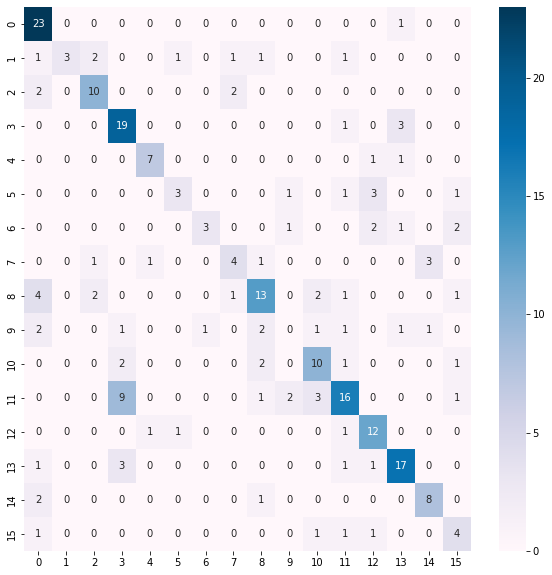

In [171]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='PuBu')

In [168]:
# model.save('/kaggle/working/catClassify_VGG16_spare.h5')